In [11]:
%reset
%env HSA_OVERRIDE_GFX_VERSION=10.3.0

env: HSA_OVERRIDE_GFX_VERSION=10.3.0


In [1]:
import os
import time

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchinfo import summary
from Classes import StockData, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# Parameters
MAIN_DATASET_LOCATION = 'StockData/Datasets/Dataset_10_v1_TrainValidate.pt'
TEST_DATASET_LOCATION = 'StockData/Datasets/Dataset_10_v1_TrainValidate.pt'

DATASET_NAME = 'DS5v1'
DATASET_SPLIT = [0.7,0.3]

INPUT_LENGTH = 90
INPUT_FEATURES = 22
OUTPUT_LENGTH = 14
OUTPUT_FEATURES = 1

NUM_EPOCHS = 30
MODEL_HIDDEN_SIZE = 256
MODEL_NUM_LAYERS = 3
BATCH_SIZE = 3

MODEL_NAME = f'{INPUT_FEATURES}IF_{MODEL_HIDDEN_SIZE}HS_{MODEL_NUM_LAYERS}L_{OUTPUT_LENGTH}OS_{DATASET_NAME}_{BATCH_SIZE}B_{NUM_EPOCHS}E'

In [13]:
torch.cuda.is_available()
device = torch.device('cuda')

In [14]:
dataset = torch.load(MAIN_DATASET_LOCATION)

In [15]:
train_dataset, validation_dataset = torch.utils.data.random_split(dataset, DATASET_SPLIT)

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE,shuffle=False, drop_last=True)

In [17]:
model = LSTM(INPUT_FEATURES, MODEL_HIDDEN_SIZE, MODEL_NUM_LAYERS, OUTPUT_LENGTH)
model.to(device)
summary(model)

LSTM(
  (lstm): LSTM(22, 256, num_layers=3, dropout=0.2)
  (fc): Linear(in_features=256, out_features=14, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

train_losses = []
test_losses = []
epoch_times = []

In [20]:
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    train_loss = 0

    # Train for epoch
    model.train()
    for inputs, targets in train_dataloader:
        inputs, targets = inputs.float().to(device), targets.float().to(device)

        optimizer.zero_grad()
        outputs = model(inputs).float()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    train_losses.append(train_loss)

    # Evaluate for epoch
    with torch.no_grad():
        test_loss = 0
        model.eval()

        for inputs, targets in validation_dataloader:
            inputs, targets = inputs.float().to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

        test_loss /= len(validation_dataloader)
        test_losses.append(test_loss)

    epoch_time = time.time() - start_time
    epoch_times.append(epoch_time)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.8f}, Test Loss: {test_loss:.8f} | Time taken: {epoch_time:.1f} seconds")

Epoch 1/50, Train Loss: 0.00106467, Test Loss: 0.00037200 | Time taken: 170.5 seconds
Epoch 2/50, Train Loss: 0.00059397, Test Loss: 0.00037587 | Time taken: 170.2 seconds
Epoch 3/50, Train Loss: 0.00054039, Test Loss: 0.00037611 | Time taken: 170.7 seconds
Epoch 4/50, Train Loss: 0.00051568, Test Loss: 0.00047101 | Time taken: 171.1 seconds
Epoch 5/50, Train Loss: 0.00048724, Test Loss: 0.00035533 | Time taken: 170.5 seconds
Epoch 6/50, Train Loss: 0.00047173, Test Loss: 0.00036902 | Time taken: 170.2 seconds
Epoch 7/50, Train Loss: 0.00046514, Test Loss: 0.00037010 | Time taken: 170.3 seconds
Epoch 8/50, Train Loss: 0.00045622, Test Loss: 0.00037584 | Time taken: 170.6 seconds
Epoch 9/50, Train Loss: 0.00044628, Test Loss: 0.00034509 | Time taken: 171.0 seconds
Epoch 10/50, Train Loss: 0.00044042, Test Loss: 0.00034508 | Time taken: 170.4 seconds
Epoch 11/50, Train Loss: 0.00043725, Test Loss: 0.00033499 | Time taken: 170.4 seconds
Epoch 12/50, Train Loss: 0.00043217, Test Loss: 0.00

In [21]:
torch.save(model.state_dict(), f'{MODEL_NAME}.pt')

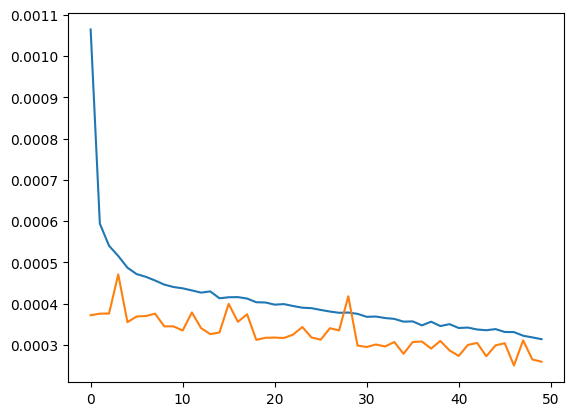

In [22]:
plt.plot(train_losses)
plt.plot(test_losses)

In [25]:
epochData = pd.DataFrame({'TrainLoss':train_losses, 'TestLoss':test_losses})
epochData.to_csv(f'{MODEL_NAME}.csv', index=False)
epochData

,TrainLoss,TestLoss
0,0.001065,0.000372
1,0.000594,0.000376
2,0.000540,0.000376
3,0.000516,0.000471
4,0.000487,0.000355
5,0.000472,0.000369
6,0.000465,0.000370
7,0.000456,0.000376
8,0.000446,0.000345
9,0.000440,0.000345
